In [63]:
import random
import time
from deap import base, creator, tools, algorithms
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import mlrose_hiive
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import fitness
from mlrose_hiive.runners import RHCRunner, SARunner, GARunner, MIMICRunner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, StandardScaler, MinMaxScaler
from concurrent.futures import ThreadPoolExecutor
from functools import partial

In [3]:
np.random.seed(24)

In [4]:
edges = [(0, 1), (0, 2), (0, 4), (1, 3), (2, 0), (2, 3), (3, 4)]

In [48]:
fitness = mlrose_hiive.MaxKColor(edges)

In [49]:
state = np.array([0, 1, 0, 1, 1])

In [50]:
def custom_fitness(state, c): return c*np.sum(state)
kwargs = {'c': 10}

fitness = mlrose_hiive.CustomFitness(custom_fitness, **kwargs)

In [51]:
iteration_list = [10000]
seed = 24
max_attempts = 100

In [14]:
%%time 

problem = mlrose_hiive.DiscreteOpt(length = len(edges), fitness_fn = fitness, 
                             maximize = True, max_val = len(edges))
problem.set_mimic_fast_mode(True)
rhc = mlrose_hiive.RHCRunner(problem, experiment_name="rhc_maxkcolor", iteration_list=iteration_list,
                                       seed=seed, max_attempts=max_attempts, restart_list=[100])
rhc_run_stats, rhc_run_curves = rhc.run()

CPU times: total: 1min 25s
Wall time: 1min 26s


In [28]:
best_index_in_curve = rhc_run_curves.Fitness.idxmax()
best_decay = rhc_run_curves.iloc[best_index_in_curve].current_restart
best_curve_rhc = rhc_run_curves.loc[rhc_run_curves.current_restart == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

0.0

Text(0, 0.5, 'Value')

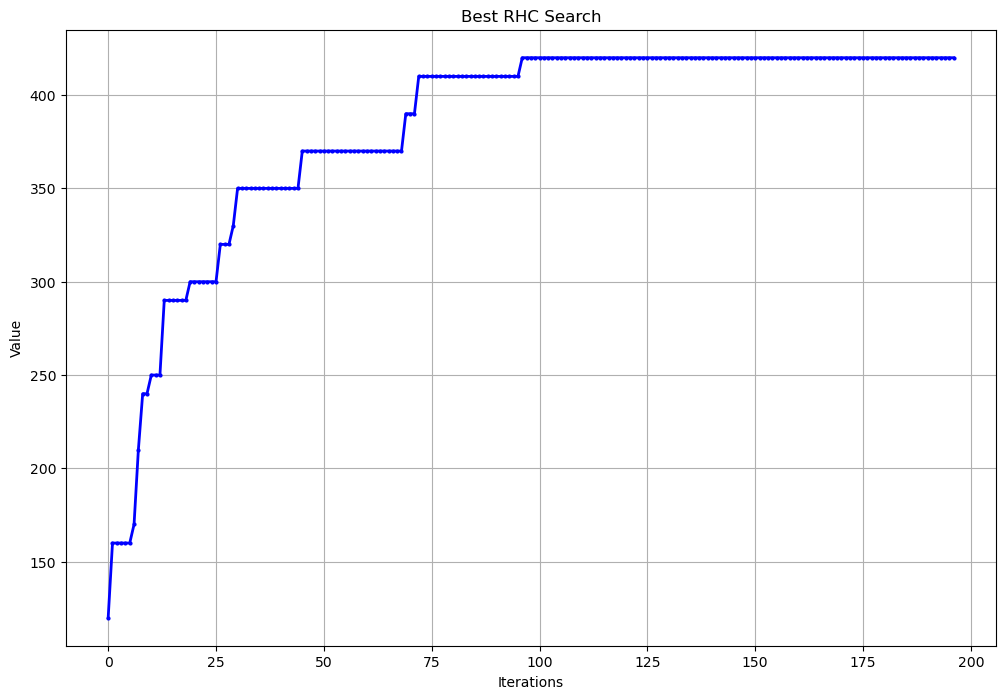

In [53]:
ax = best_curve_rhc.Fitness.plot(lw=2, colormap='winter', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Best RHC Search')
ax.set_xlabel("Iterations")
ax.set_ylabel("Value")

In [17]:
last_iters = rhc_run_stats[rhc_run_stats.Iteration != 0].reset_index()
print(last_iters.Fitness.mean(), last_iters.Fitness.max())
print(last_iters.Time.max())

419.3069306930693 420.0
86.84635239999625


In [18]:
rhc_run_curves

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.004666,120.0,0.0,100,10000,0
1,1,0.009546,160.0,2.0,100,10000,0
2,2,0.009618,160.0,3.0,100,10000,0
3,3,0.009700,160.0,4.0,100,10000,0
4,4,0.009804,160.0,5.0,100,10000,0
...,...,...,...,...,...,...,...
19709,174,0.029987,420.0,20841.0,100,10000,100
19710,175,0.030080,420.0,20842.0,100,10000,100
19711,176,0.030169,420.0,20843.0,100,10000,100
19712,177,0.030271,420.0,20844.0,100,10000,100


In [42]:
%%time
sim_annealing = mlrose_hiive.SARunner(problem, experiment_name="sim_ann", 
                           iteration_list=iteration_list,
                           temperature_list=[1, 5, 10, 100, 250, 500, 750, 1000, 5000, 10000],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=seed, max_attempts=max_attempts)
sa_run_stats, sa_run_curves = sim_annealing.run()   

CPU times: total: 3.77 s
Wall time: 5.14 s


In [43]:
final_iterations = sa_run_stats[sa_run_stats.Iteration != 0].reset_index()

print(final_iterations.Fitness.mean(), final_iterations.Fitness.max())
print(final_iterations.Time.mean())

420.0 420.0
0.2353786299994681


In [44]:
best_idx = sa_run_curves.Fitness.idxmax()
best_decay = sa_run_curves.iloc[best_idx].Temperature
best_curve = sa_run_curves.loc[sa_run_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ExpDecay(init_temp=1, exp_const=0.005, min_temp=0.001)

Text(0, 0.5, 'Value')

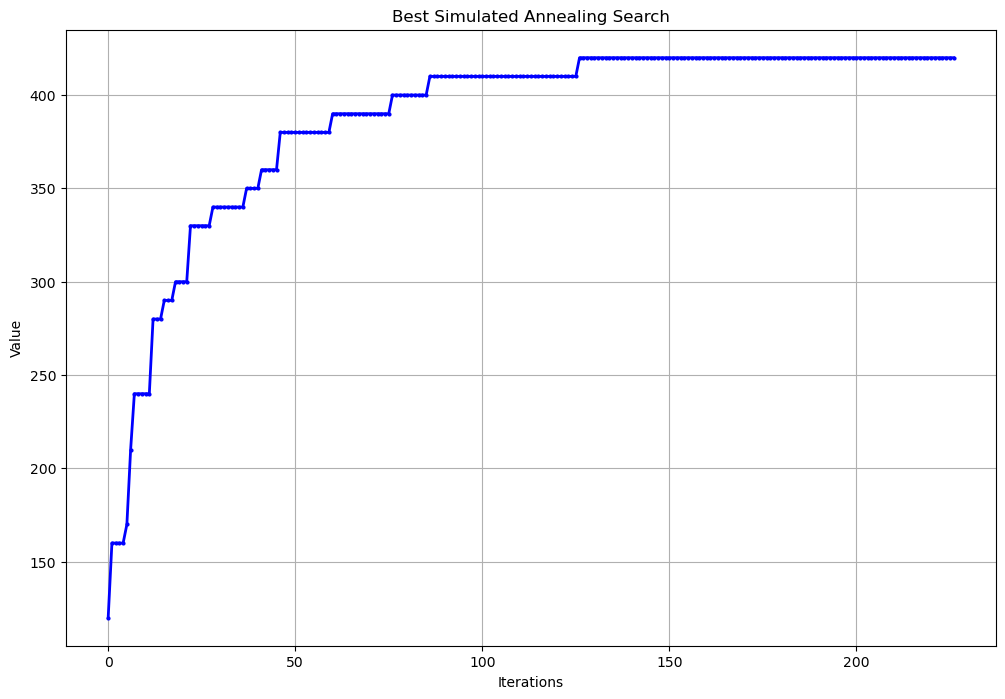

In [54]:
ax = best_curve.Fitness.plot(lw=2, colormap='winter', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Best Simulated Annealing Search')
ax.set_xlabel("Iterations")
ax.set_ylabel("Value")

In [46]:
%%time
gen_alg = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="gen_alg",
                          seed=seed,
                          iteration_list=iteration_list,
                          max_attempts=max_attempts,
                          population_sizes=[50, 200, 500, 1000],
                          mutation_rates=[0.1, 0.25, 0.5, 0.75])
ga_run_stats, ga_run_curves = gen_alg.run()  

CPU times: total: 1min 6s
Wall time: 1min 22s


In [47]:
final_iterations = ga_run_stats[ga_run_stats.Iteration != 0].reset_index()


print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Mutation Rate").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

420.0 420.0 5.173993199990946
Mutation Rate
0.10    420.0
0.25    420.0
0.50    420.0
0.75    420.0
Name: Fitness, dtype: float64
Population Size
50      420.0
200     420.0
500     420.0
1000    420.0
Name: Fitness, dtype: float64
Population Size
50       0.549439
200      2.043603
500      6.677418
1000    11.425514
Name: Time, dtype: float64


Text(0, 0.5, 'Time in Seconds')

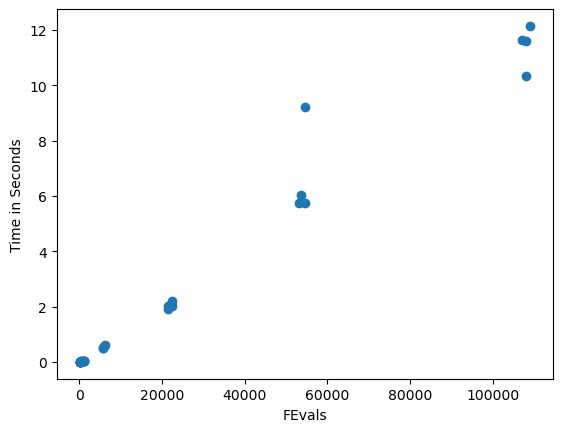

In [52]:
plt.scatter(x=ga_run_stats['FEvals'], y=ga_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")

In [62]:
%%time
mimic = mlrose_hiive.MIMICRunner(problem=problem, experiment_name="mimic", seed=seed,
                  iteration_list=iteration_list, max_attempts=200,
                  population_sizes=[50, 200, 500, 1000], keep_percent_list=[0.10, 0.25, 0.5, 0.75], use_fast_mimic=True)

# the two data frames will contain the results
mmc_run_stats, mmc_run_curves = mimic.run()

CPU times: total: 35.3 s
Wall time: 43 s


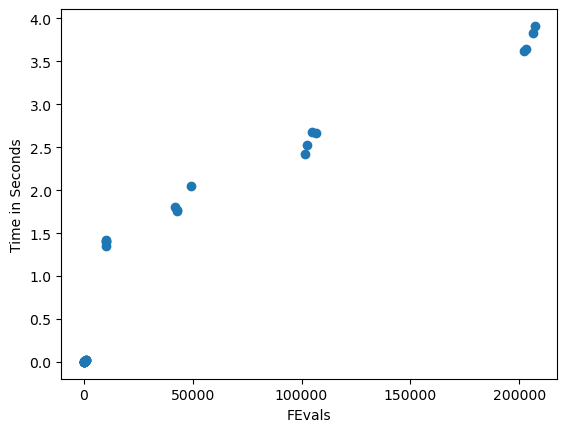

In [61]:
plt.scatter(x=mmc_run_stats['FEvals'], y=mmc_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")
plt.show()

In [56]:
final_iterations = mmc_run_stats[mmc_run_stats.Iteration != 0].reset_index()
print("Max and mean")
print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Keep Percent").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

Max and mean
420.0 403.75 1.270316649999586
Keep Percent
0.10    395.0
0.25    407.5
0.50    410.0
0.75    402.5
Name: Fitness, dtype: float64
Population Size
50      360.0
200     415.0
500     420.0
1000    420.0
Name: Fitness, dtype: float64
Population Size
50      0.793702
200     1.030242
500     1.312607
1000    1.944715
Name: Time, dtype: float64


In [64]:
pip list --format=freeze > pip-requirements.txt

Note: you may need to restart the kernel to use updated packages.
